In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [35]:
"""This file contains code for use with "Think Bayes",
by Allen B. Downey, available from greenteapress.com

Copyright 2012 Allen B. Downey
License: GNU GPLv3 http://www.gnu.org/licenses/gpl.html
"""

"""This file contains class definitions for:

Hist: represents a histogram (map from values to integer frequencies).

Pmf: represents a probability mass function (map from values to probs).

_DictWrapper: private parent class for Hist and Pmf.

Cdf: represents a discrete cumulative distribution function

Pdf: represents a continuous probability density function

"""

import bisect
import copy
import logging
import math
import numpy
import random

import scipy.stats
from scipy.special import erf, erfinv


def Odds(p):
    """Computes odds for a given probability.

    Example: p=0.75 means 75 for and 25 against, or 3:1 odds in favor.

    Note: when p=1, the formula for odds divides by zero, which is
    normally undefined.  But I think it is reasonable to define Odds(1)
    to be infinity, so that's what this function does.

    p: float 0-1

    Returns: float odds
    """
    if p == 1:
        return float('inf')
    return p / (1 - p)


def Probability(o):
    """Computes the probability corresponding to given odds.

    Example: o=2 means 2:1 odds in favor, or 2/3 probability

    o: float odds, strictly positive

    Returns: float probability
    """
    return o / (o + 1)


def Probability2(yes, no):
    """Computes the probability corresponding to given odds.

    Example: yes=2, no=1 means 2:1 odds in favor, or 2/3 probability.
    
    yes, no: int or float odds in favor
    """
    return float(yes) / (yes + no)


class Interpolator(object):
    """Represents a mapping between sorted sequences; performs linear interp.

    Attributes:
        xs: sorted list
        ys: sorted list
    """

    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys

    def Lookup(self, x):
        """Looks up x and returns the corresponding value of y."""
        return self._Bisect(x, self.xs, self.ys)

    def Reverse(self, y):
        """Looks up y and returns the corresponding value of x."""
        return self._Bisect(y, self.ys, self.xs)

    def _Bisect(self, x, xs, ys):
        """Helper function."""
        if x <= xs[0]:
            return ys[0]
        if x >= xs[-1]:
            return ys[-1]
        i = bisect.bisect(xs, x)
        frac = 1.0 * (x - xs[i - 1]) / (xs[i] - xs[i - 1])
        y = ys[i - 1] + frac * 1.0 * (ys[i] - ys[i - 1])
        return y


class _DictWrapper(object):
    """An object that contains a dictionary."""

    def __init__(self, values=None, name=''):
        """Initializes the distribution.

        hypos: sequence of hypotheses
        """
        self.name = name
        self.d = {}

        # flag whether the distribution is under a log transform
        self.log = False

        if values is None:
            return

        init_methods = [
            self.InitPmf,
            self.InitMapping,
            self.InitSequence,
            self.InitFailure,
            ]

        for method in init_methods:
            try:
                method(values)
                break
            except AttributeError:
                continue

        if len(self) > 0:
            self.Normalize()

    def InitSequence(self, values):
        """Initializes with a sequence of equally-likely values.

        values: sequence of values
        """
        for value in values:
            self.Set(value, 1)

    def InitMapping(self, values):
        """Initializes with a map from value to probability.

        values: map from value to probability
        """
        for value, prob in values.iteritems():
            self.Set(value, prob)

    def InitPmf(self, values):
        """Initializes with a Pmf.

        values: Pmf object
        """
        for value, prob in values.Items():
            self.Set(value, prob)

    def InitFailure(self, values):
        """Raises an error."""
        raise ValueError('None of the initialization methods worked.')

    def __len__(self):
        return len(self.d)

    def __iter__(self):
        return iter(self.d)

    def iterkeys(self):
        return iter(self.d)

    def __contains__(self, value):
        return value in self.d

    def Copy(self, name=None):
        """Returns a copy.

        Make a shallow copy of d.  If you want a deep copy of d,
        use copy.deepcopy on the whole object.

        Args:
            name: string name for the new Hist
        """
        new = copy.copy(self)
        new.d = copy.copy(self.d)
        new.name = name if name is not None else self.name
        return new

    def Scale(self, factor):
        """Multiplies the values by a factor.

        factor: what to multiply by

        Returns: new object
        """
        new = self.Copy()
        new.d.clear()

        for val, prob in self.Items():
            new.Set(val * factor, prob)
        return new

    def Log(self, m=None):
        """Log transforms the probabilities.
        
        Removes values with probability 0.

        Normalizes so that the largest logprob is 0.
        """
        if self.log:
            raise ValueError("Pmf/Hist already under a log transform")
        self.log = True

        if m is None:
            m = self.MaxLike()

        for x, p in self.d.iteritems():
            if p:
                self.Set(x, math.log(p / m))
            else:
                self.Remove(x)

    def Exp(self, m=None):
        """Exponentiates the probabilities.

        m: how much to shift the ps before exponentiating

        If m is None, normalizes so that the largest prob is 1.
        """
        if not self.log:
            raise ValueError("Pmf/Hist not under a log transform")
        self.log = False

        if m is None:
            m = self.MaxLike()

        for x, p in self.d.iteritems():
            self.Set(x, math.exp(p - m))

    def GetDict(self):
        """Gets the dictionary."""
        return self.d

    def SetDict(self, d):
        """Sets the dictionary."""
        self.d = d

    def Values(self):
        """Gets an unsorted sequence of values.

        Note: one source of confusion is that the keys of this
        dictionary are the values of the Hist/Pmf, and the
        values of the dictionary are frequencies/probabilities.
        """
        return self.d.keys()

    def Items(self):
        """Gets an unsorted sequence of (value, freq/prob) pairs."""
        return self.d.items()

    def Render(self):
        """Generates a sequence of points suitable for plotting.

        Returns:
            tuple of (sorted value sequence, freq/prob sequence)
        """
        return zip(*sorted(self.Items()))

    def Print(self):
        """Prints the values and freqs/probs in ascending order."""
        for val, prob in sorted(self.d.iteritems()):
            print(val, prob)

    def Set(self, x, y=0):
        """Sets the freq/prob associated with the value x.

        Args:
            x: number value
            y: number freq or prob
        """
        self.d[x] = y

    def Incr(self, x, term=1):
        """Increments the freq/prob associated with the value x.

        Args:
            x: number value
            term: how much to increment by
        """
        self.d[x] = self.d.get(x, 0) + term

    def Mult(self, x, factor):
        """Scales the freq/prob associated with the value x.

        Args:
            x: number value
            factor: how much to multiply by
        """
        self.d[x] = self.d.get(x, 0) * factor

    def Remove(self, x):
        """Removes a value.

        Throws an exception if the value is not there.

        Args:
            x: value to remove
        """
        del self.d[x]

    def Total(self):
        """Returns the total of the frequencies/probabilities in the map."""
        total = sum(self.d.itervalues())
        return total

    def MaxLike(self):
        """Returns the largest frequency/probability in the map."""
        return max(self.d.itervalues())


class Hist(_DictWrapper):
    """Represents a histogram, which is a map from values to frequencies.

    Values can be any hashable type; frequencies are integer counters.
    """

    def Freq(self, x):
        """Gets the frequency associated with the value x.

        Args:
            x: number value

        Returns:
            int frequency
        """
        return self.d.get(x, 0)

    def Freqs(self, xs):
        """Gets frequencies for a sequence of values."""
        return [self.Freq(x) for x in xs]

    def IsSubset(self, other):
        """Checks whether the values in this histogram are a subset of
        the values in the given histogram."""
        for val, freq in self.Items():
            if freq > other.Freq(val):
                return False
        return True

    def Subtract(self, other):
        """Subtracts the values in the given histogram from this histogram."""
        for val, freq in other.Items():
            self.Incr(val, -freq)


class Pmf(_DictWrapper):
    """Represents a probability mass function.
    
    Values can be any hashable type; probabilities are floating-point.
    Pmfs are not necessarily normalized.
    """

    def Prob(self, x, default=0):
        """Gets the probability associated with the value x.

        Args:
            x: number value
            default: value to return if the key is not there

        Returns:
            float probability
        """
        return self.d.get(x, default)

    def Probs(self, xs):
        """Gets probabilities for a sequence of values."""
        return [self.Prob(x) for x in xs]

    def MakeCdf(self, name=None):
        """Makes a Cdf."""
        return MakeCdfFromPmf(self, name=name)

    def ProbGreater(self, x):
        t = [prob for (val, prob) in self.d.iteritems() if val > x]
        return sum(t)

    def ProbLess(self, x):
        t = [prob for (val, prob) in self.d.iteritems() if val < x]
        return sum(t)

    def Normalize(self, fraction=1.0):
        """Normalizes this PMF so the sum of all probs is fraction.

        Args:
            fraction: what the total should be after normalization

        Returns: the total probability before normalizing
        """
        if self.log:
            raise ValueError("Pmf is under a log transform")

        total = self.Total()
        if total == 0.0:
            raise ValueError('total probability is zero.')
            logging.warning('Normalize: total probability is zero.')
            return total

        factor = float(fraction) / total
        for x in self.d:
            self.d[x] *= factor

        return total

    def Random(self):
        """Chooses a random element from this PMF.

        Returns:
            float value from the Pmf
        """
        if len(self.d) == 0:
            raise ValueError('Pmf contains no values.')

        target = random.random()
        total = 0.0
        for x, p in self.d.iteritems():
            total += p
            if total >= target:
                return x

        # we shouldn't get here
        assert False

    def Mean(self):
        """Computes the mean of a PMF.

        Returns:
            float mean
        """
        mu = 0.0
        for x, p in self.d.iteritems():
            mu += p * x
        return mu

    def Var(self, mu=None):
        """Computes the variance of a PMF.

        Args:
            mu: the point around which the variance is computed;
                if omitted, computes the mean

        Returns:
            float variance
        """
        if mu is None:
            mu = self.Mean()

        var = 0.0
        for x, p in self.d.iteritems():
            var += p * (x - mu) ** 2
        return var

    def MaximumLikelihood(self):
        """Returns the value with the highest probability.

        Returns: float probability
        """
        prob, val = max((prob, val) for val, prob in self.Items())
        return val

    def CredibleInterval(self, percentage=90):
        """Computes the central credible interval.

        If percentage=90, computes the 90% CI.

        Args:
            percentage: float between 0 and 100

        Returns:
            sequence of two floats, low and high
        """
        cdf = self.MakeCdf()
        return cdf.CredibleInterval(percentage)

    def __add__(self, other):
        """Computes the Pmf of the sum of values drawn from self and other.

        other: another Pmf

        returns: new Pmf
        """
        try:
            return self.AddPmf(other)
        except AttributeError:
            return self.AddConstant(other)

    def AddPmf(self, other):
        """Computes the Pmf of the sum of values drawn from self and other.

        other: another Pmf

        returns: new Pmf
        """
        pmf = Pmf()
        for v1, p1 in self.Items():
            for v2, p2 in other.Items():
                pmf.Incr(v1 + v2, p1 * p2)
        return pmf

    def AddConstant(self, other):
        """Computes the Pmf of the sum a constant and  values from self.

        other: a number

        returns: new Pmf
        """
        pmf = Pmf()
        for v1, p1 in self.Items():
            pmf.Set(v1 + other, p1)
        return pmf

    def __sub__(self, other):
        """Computes the Pmf of the diff of values drawn from self and other.

        other: another Pmf

        returns: new Pmf
        """
        pmf = Pmf()
        for v1, p1 in self.Items():
            for v2, p2 in other.Items():
                pmf.Incr(v1 - v2, p1 * p2)
        return pmf

    def Max(self, k):
        """Computes the CDF of the maximum of k selections from this dist.

        k: int

        returns: new Cdf
        """
        cdf = self.MakeCdf()
        cdf.ps = [p ** k for p in cdf.ps]
        return cdf


class Joint(Pmf):
    """Represents a joint distribution.

    The values are sequences (usually tuples)
    """

    def Marginal(self, i, name=''):
        """Gets the marginal distribution of the indicated variable.

        i: index of the variable we want

        Returns: Pmf
        """
        pmf = Pmf(name=name)
        for vs, prob in self.Items():
            pmf.Incr(vs[i], prob)
        return pmf

    def Conditional(self, i, j, val, name=''):
        """Gets the conditional distribution of the indicated variable.

        Distribution of vs[i], conditioned on vs[j] = val.

        i: index of the variable we want
        j: which variable is conditioned on
        val: the value the jth variable has to have

        Returns: Pmf
        """
        pmf = Pmf(name=name)
        for vs, prob in self.Items():
            if vs[j] != val: continue
            pmf.Incr(vs[i], prob)

        pmf.Normalize()
        return pmf

    def MaxLikeInterval(self, percentage=90):
        """Returns the maximum-likelihood credible interval.

        If percentage=90, computes a 90% CI containing the values
        with the highest likelihoods.

        percentage: float between 0 and 100

        Returns: list of values from the suite
        """
        interval = []
        total = 0

        t = [(prob, val) for val, prob in self.Items()]
        t.sort(reverse=True)

        for prob, val in t:
            interval.append(val)
            total += prob
            if total >= percentage / 100.0:
                break

        return interval


def MakeJoint(pmf1, pmf2):
    """Joint distribution of values from pmf1 and pmf2.

    Args:
        pmf1: Pmf object
        pmf2: Pmf object

    Returns:
        Joint pmf of value pairs
    """
    joint = Joint()
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            joint.Set((v1, v2), p1 * p2)
    return joint


def MakeHistFromList(t, name=''):
    """Makes a histogram from an unsorted sequence of values.

    Args:
        t: sequence of numbers
        name: string name for this histogram

    Returns:
        Hist object
    """
    hist = Hist(name=name)
    [hist.Incr(x) for x in t]
    return hist


def MakeHistFromDict(d, name=''):
    """Makes a histogram from a map from values to frequencies.

    Args:
        d: dictionary that maps values to frequencies
        name: string name for this histogram

    Returns:
        Hist object
    """
    return Hist(d, name)


def MakePmfFromList(t, name=''):
    """Makes a PMF from an unsorted sequence of values.

    Args:
        t: sequence of numbers
        name: string name for this PMF

    Returns:
        Pmf object
    """
    hist = MakeHistFromList(t)
    d = hist.GetDict()
    pmf = Pmf(d, name)
    pmf.Normalize()
    return pmf


def MakePmfFromDict(d, name=''):
    """Makes a PMF from a map from values to probabilities.

    Args:
        d: dictionary that maps values to probabilities
        name: string name for this PMF

    Returns:
        Pmf object
    """
    pmf = Pmf(d, name)
    pmf.Normalize()
    return pmf


def MakePmfFromItems(t, name=''):
    """Makes a PMF from a sequence of value-probability pairs

    Args:
        t: sequence of value-probability pairs
        name: string name for this PMF

    Returns:
        Pmf object
    """
    pmf = Pmf(dict(t), name)
    pmf.Normalize()
    return pmf


def MakePmfFromHist(hist, name=None):
    """Makes a normalized PMF from a Hist object.

    Args:
        hist: Hist object
        name: string name

    Returns:
        Pmf object
    """
    if name is None:
        name = hist.name

    # make a copy of the dictionary
    d = dict(hist.GetDict())
    pmf = Pmf(d, name)
    pmf.Normalize()
    return pmf


def MakePmfFromCdf(cdf, name=None):
    """Makes a normalized Pmf from a Cdf object.

    Args:
        cdf: Cdf object
        name: string name for the new Pmf

    Returns:
        Pmf object
    """
    if name is None:
        name = cdf.name

    pmf = Pmf(name=name)

    prev = 0.0
    for val, prob in cdf.Items():
        pmf.Incr(val, prob - prev)
        prev = prob

    return pmf


def MakeMixture(metapmf, name='mix'):
    """Make a mixture distribution.

    Args:
      metapmf: Pmf that maps from Pmfs to probs.
      name: string name for the new Pmf.

    Returns: Pmf object.
    """
    mix = Pmf(name=name)
    for pmf, p1 in metapmf.Items():
        for x, p2 in pmf.Items():
            mix.Incr(x, p1 * p2)
    return mix


def MakeUniformPmf(low, high, n):
    """Make a uniform Pmf.

    low: lowest value (inclusive)
    high: highest value (inclusize)
    n: number of values
    """
    pmf = Pmf()
    for x in numpy.linspace(low, high, n):
        pmf.Set(x, 1)
    pmf.Normalize()
    return pmf


class Cdf(object):
    """Represents a cumulative distribution function.

    Attributes:
        xs: sequence of values
        ps: sequence of probabilities
        name: string used as a graph label.
    """

    def __init__(self, xs=None, ps=None, name=''):
        self.xs = [] if xs is None else xs
        self.ps = [] if ps is None else ps
        self.name = name

    def Copy(self, name=None):
        """Returns a copy of this Cdf.

        Args:
            name: string name for the new Cdf
        """
        if name is None:
            name = self.name
        return Cdf(list(self.xs), list(self.ps), name)

    def MakePmf(self, name=None):
        """Makes a Pmf."""
        return MakePmfFromCdf(self, name=name)

    def Values(self):
        """Returns a sorted list of values.
        """
        return self.xs

    def Items(self):
        """Returns a sorted sequence of (value, probability) pairs.

        Note: in Python3, returns an iterator.
        """
        return zip(self.xs, self.ps)

    def Append(self, x, p):
        """Add an (x, p) pair to the end of this CDF.

        Note: this us normally used to build a CDF from scratch, not
        to modify existing CDFs.  It is up to the caller to make sure
        that the result is a legal CDF.
        """
        self.xs.append(x)
        self.ps.append(p)

    def Shift(self, term):
        """Adds a term to the xs.

        term: how much to add
        """
        new = self.Copy()
        new.xs = [x + term for x in self.xs]
        return new

    def Scale(self, factor):
        """Multiplies the xs by a factor.

        factor: what to multiply by
        """
        new = self.Copy()
        new.xs = [x * factor for x in self.xs]
        return new

    def Prob(self, x):
        """Returns CDF(x), the probability that corresponds to value x.

        Args:
            x: number

        Returns:
            float probability
        """
        if x < self.xs[0]: return 0.0
        index = bisect.bisect(self.xs, x)
        p = self.ps[index - 1]
        return p

    def Value(self, p):
        """Returns InverseCDF(p), the value that corresponds to probability p.

        Args:
            p: number in the range [0, 1]

        Returns:
            number value
        """
        if p < 0 or p > 1:
            raise ValueError('Probability p must be in range [0, 1]')

        if p == 0: return self.xs[0]
        if p == 1: return self.xs[-1]
        index = bisect.bisect(self.ps, p)
        if p == self.ps[index - 1]:
            return self.xs[index - 1]
        else:
            return self.xs[index]

    def Percentile(self, p):
        """Returns the value that corresponds to percentile p.

        Args:
            p: number in the range [0, 100]

        Returns:
            number value
        """
        return self.Value(p / 100.0)

    def Random(self):
        """Chooses a random value from this distribution."""
        return self.Value(random.random())

    def Sample(self, n):
        """Generates a random sample from this distribution.
        
        Args:
            n: int length of the sample
        """
        return [self.Random() for i in range(n)]

    def Mean(self):
        """Computes the mean of a CDF.

        Returns:
            float mean
        """
        old_p = 0
        total = 0.0
        for x, new_p in zip(self.xs, self.ps):
            p = new_p - old_p
            total += p * x
            old_p = new_p
        return total

    def CredibleInterval(self, percentage=90):
        """Computes the central credible interval.

        If percentage=90, computes the 90% CI.

        Args:
            percentage: float between 0 and 100

        Returns:
            sequence of two floats, low and high
        """
        prob = (1 - percentage / 100.0) / 2
        interval = self.Value(prob), self.Value(1 - prob)
        return interval

    def _Round(self, multiplier=1000.0):
        """
        An entry is added to the cdf only if the percentile differs
        from the previous value in a significant digit, where the number
        of significant digits is determined by multiplier.  The
        default is 1000, which keeps log10(1000) = 3 significant digits.
        """
        # TODO(write this method)
        raise UnimplementedMethodException()

    def Render(self):
        """Generates a sequence of points suitable for plotting.

        An empirical CDF is a step function; linear interpolation
        can be misleading.

        Returns:
            tuple of (xs, ps)
        """
        xs = [self.xs[0]]
        ps = [0.0]
        for i, p in enumerate(self.ps):
            xs.append(self.xs[i])
            ps.append(p)

            try:
                xs.append(self.xs[i + 1])
                ps.append(p)
            except IndexError:
                pass
        return xs, ps

    def Max(self, k):
        """Computes the CDF of the maximum of k selections from this dist.

        k: int

        returns: new Cdf
        """
        cdf = self.Copy()
        cdf.ps = [p ** k for p in cdf.ps]
        return cdf


def MakeCdfFromItems(items, name=''):
    """Makes a cdf from an unsorted sequence of (value, frequency) pairs.

    Args:
        items: unsorted sequence of (value, frequency) pairs
        name: string name for this CDF

    Returns:
        cdf: list of (value, fraction) pairs
    """
    runsum = 0
    xs = []
    cs = []

    for value, count in sorted(items):
        runsum += count
        xs.append(value)
        cs.append(runsum)

    total = float(runsum)
    ps = [c / total for c in cs]

    cdf = Cdf(xs, ps, name)
    return cdf


def MakeCdfFromDict(d, name=''):
    """Makes a CDF from a dictionary that maps values to frequencies.

    Args:
       d: dictionary that maps values to frequencies.
       name: string name for the data.

    Returns:
        Cdf object
    """
    return MakeCdfFromItems(d.iteritems(), name)


def MakeCdfFromHist(hist, name=''):
    """Makes a CDF from a Hist object.

    Args:
       hist: Pmf.Hist object
       name: string name for the data.

    Returns:
        Cdf object
    """
    return MakeCdfFromItems(hist.Items(), name)


def MakeCdfFromPmf(pmf, name=None):
    """Makes a CDF from a Pmf object.

    Args:
       pmf: Pmf.Pmf object
       name: string name for the data.

    Returns:
        Cdf object
    """
    if name == None:
        name = pmf.name
    return MakeCdfFromItems(pmf.Items(), name)


def MakeCdfFromList(seq, name=''):
    """Creates a CDF from an unsorted sequence.

    Args:
        seq: unsorted sequence of sortable values
        name: string name for the cdf

    Returns:
       Cdf object
    """
    hist = MakeHistFromList(seq)
    return MakeCdfFromHist(hist, name)


class UnimplementedMethodException(Exception):
    """Exception if someone calls a method that should be overridden."""


class Suite(Pmf):
    """Represents a suite of hypotheses and their probabilities."""

    def Update(self, data):
        """Updates each hypothesis based on the data.

        data: any representation of the data

        returns: the normalizing constant
        """
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        return self.Normalize()

    def LogUpdate(self, data):
        """Updates a suite of hypotheses based on new data.

        Modifies the suite directly; if you want to keep the original, make
        a copy.

        Note: unlike Update, LogUpdate does not normalize.

        Args:
            data: any representation of the data
        """
        for hypo in self.Values():
            like = self.LogLikelihood(data, hypo)
            self.Incr(hypo, like)

    def UpdateSet(self, dataset):
        """Updates each hypothesis based on the dataset.

        This is more efficient than calling Update repeatedly because
        it waits until the end to Normalize.

        Modifies the suite directly; if you want to keep the original, make
        a copy.

        dataset: a sequence of data

        returns: the normalizing constant
        """
        for data in dataset:
            for hypo in self.Values():
                like = self.Likelihood(data, hypo)
                self.Mult(hypo, like)
        return self.Normalize()

    def LogUpdateSet(self, dataset):
        """Updates each hypothesis based on the dataset.

        Modifies the suite directly; if you want to keep the original, make
        a copy.

        dataset: a sequence of data

        returns: None
        """
        for data in dataset:
            self.LogUpdate(data)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: some representation of the hypothesis
        data: some representation of the data
        """
        raise UnimplementedMethodException()

    def LogLikelihood(self, data, hypo):
        """Computes the log likelihood of the data under the hypothesis.

        hypo: some representation of the hypothesis
        data: some representation of the data
        """
        raise UnimplementedMethodException()

    def Print(self):
        """Prints the hypotheses and their probabilities."""
        for hypo, prob in sorted(self.Items()):
            print(hypo, prob)

    def MakeOdds(self):
        """Transforms from probabilities to odds.

        Values with prob=0 are removed.
        """
        for hypo, prob in self.Items():
            if prob:
                self.Set(hypo, Odds(prob))
            else:
                self.Remove(hypo)

    def MakeProbs(self):
        """Transforms from odds to probabilities."""
        for hypo, odds in self.Items():
            self.Set(hypo, Probability(odds))


def MakeSuiteFromList(t, name=''):
    """Makes a suite from an unsorted sequence of values.

    Args:
        t: sequence of numbers
        name: string name for this suite

    Returns:
        Suite object
    """
    hist = MakeHistFromList(t)
    d = hist.GetDict()
    return MakeSuiteFromDict(d)


def MakeSuiteFromHist(hist, name=None):
    """Makes a normalized suite from a Hist object.

    Args:
        hist: Hist object
        name: string name

    Returns:
        Suite object
    """
    if name is None:
        name = hist.name

    # make a copy of the dictionary
    d = dict(hist.GetDict())
    return MakeSuiteFromDict(d, name)


def MakeSuiteFromDict(d, name=''):
    """Makes a suite from a map from values to probabilities.

    Args:
        d: dictionary that maps values to probabilities
        name: string name for this suite

    Returns:
        Suite object
    """
    suite = Suite(name=name)
    suite.SetDict(d)
    suite.Normalize()
    return suite


def MakeSuiteFromCdf(cdf, name=None):
    """Makes a normalized Suite from a Cdf object.

    Args:
        cdf: Cdf object
        name: string name for the new Suite

    Returns:
        Suite object
    """
    if name is None:
        name = cdf.name

    suite = Suite(name=name)

    prev = 0.0
    for val, prob in cdf.Items():
        suite.Incr(val, prob - prev)
        prev = prob

    return suite


class Pdf(object):
    """Represents a probability density function (PDF)."""

    def Density(self, x):
        """Evaluates this Pdf at x.

        Returns: float probability density
        """
        raise UnimplementedMethodException()

    def MakePmf(self, xs, name=''):
        """Makes a discrete version of this Pdf, evaluated at xs.

        xs: equally-spaced sequence of values

        Returns: new Pmf
        """
        pmf = Pmf(name=name)
        for x in xs:
            pmf.Set(x, self.Density(x))
        pmf.Normalize()
        return pmf


class GaussianPdf(Pdf):
    """Represents the PDF of a Gaussian distribution."""

    def __init__(self, mu, sigma):
        """Constructs a Gaussian Pdf with given mu and sigma.

        mu: mean
        sigma: standard deviation
        """
        self.mu = mu
        self.sigma = sigma

    def Density(self, x):
        """Evaluates this Pdf at x.

        Returns: float probability density
        """
        return EvalGaussianPdf(x, self.mu, self.sigma)


class EstimatedPdf(Pdf):
    """Represents a PDF estimated by KDE."""

    def __init__(self, sample):
        """Estimates the density function based on a sample.

        sample: sequence of data
        """
        self.kde = scipy.stats.gaussian_kde(sample)

    def Density(self, x):
        """Evaluates this Pdf at x.

        Returns: float probability density
        """
        return self.kde.evaluate(x)

    def MakePmf(self, xs, name=''):
        ps = self.kde.evaluate(xs)
        pmf = MakePmfFromItems(zip(xs, ps), name=name)
        return pmf


def Percentile(pmf, percentage):
    """Computes a percentile of a given Pmf.

    percentage: float 0-100
    """
    p = percentage / 100.0
    total = 0
    for val, prob in pmf.Items():
        total += prob
        if total >= p:
            return val


def CredibleInterval(pmf, percentage=90):
    """Computes a credible interval for a given distribution.

    If percentage=90, computes the 90% CI.

    Args:
        pmf: Pmf object representing a posterior distribution
        percentage: float between 0 and 100

    Returns:
        sequence of two floats, low and high
    """
    cdf = pmf.MakeCdf()
    prob = (1 - percentage / 100.0) / 2
    interval = cdf.Value(prob), cdf.Value(1 - prob)
    return interval


def PmfProbLess(pmf1, pmf2):
    """Probability that a value from pmf1 is less than a value from pmf2.

    Args:
        pmf1: Pmf object
        pmf2: Pmf object

    Returns:
        float probability
    """
    total = 0.0
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            if v1 < v2:
                total += p1 * p2
    return total


def PmfProbGreater(pmf1, pmf2):
    """Probability that a value from pmf1 is less than a value from pmf2.

    Args:
        pmf1: Pmf object
        pmf2: Pmf object

    Returns:
        float probability
    """
    total = 0.0
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            if v1 > v2:
                total += p1 * p2
    return total


def PmfProbEqual(pmf1, pmf2):
    """Probability that a value from pmf1 equals a value from pmf2.

    Args:
        pmf1: Pmf object
        pmf2: Pmf object

    Returns:
        float probability
    """
    total = 0.0
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            if v1 == v2:
                total += p1 * p2
    return total


def RandomSum(dists):
    """Chooses a random value from each dist and returns the sum.

    dists: sequence of Pmf or Cdf objects

    returns: numerical sum
    """
    total = sum(dist.Random() for dist in dists)
    return total


def SampleSum(dists, n):
    """Draws a sample of sums from a list of distributions.

    dists: sequence of Pmf or Cdf objects
    n: sample size

    returns: new Pmf of sums
    """
    pmf = MakePmfFromList(RandomSum(dists) for i in xrange(n))
    return pmf


def EvalGaussianPdf(x, mu, sigma):
    """Computes the unnormalized PDF of the normal distribution.

    x: value
    mu: mean
    sigma: standard deviation
    
    returns: float probability density
    """
    return scipy.stats.norm.pdf(x, mu, sigma)


def MakeGaussianPmf(mu, sigma, num_sigmas, n=201):
    """Makes a PMF discrete approx to a Gaussian distribution.
    
    mu: float mean
    sigma: float standard deviation
    num_sigmas: how many sigmas to extend in each direction
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    pmf = Pmf()
    low = mu - num_sigmas * sigma
    high = mu + num_sigmas * sigma

    for x in numpy.linspace(low, high, n):
        p = EvalGaussianPdf(x, mu, sigma)
        pmf.Set(x, p)
    pmf.Normalize()
    return pmf


def EvalBinomialPmf(k, n, p):
    """Evaluates the binomial pmf.

    Returns the probabily of k successes in n trials with probability p.
    """
    return scipy.stats.binom.pmf(k, n, p)
    

def EvalPoissonPmf(k, lam):
    """Computes the Poisson PMF.

    k: number of events
    lam: parameter lambda in events per unit time

    returns: float probability
    """
    # don't use the scipy function.  for lam=0 it returns NaN;
    # should be 0.0
    return scipy.stats.poisson.pmf(k, lam)

    #return lam ** k * math.exp(-lam) / math.factorial(k)


def MakePoissonPmf(lam, high, step=1):
    """Makes a PMF discrete approx to a Poisson distribution.

    lam: parameter lambda in events per unit time
    high: upper bound of the Pmf

    returns: normalized Pmf
    """
    pmf = Pmf()
    for k in xrange(0, high + 1, step):
        p = EvalPoissonPmf(k, lam)
        pmf.Set(k, p)
    pmf.Normalize()
    return pmf


def EvalExponentialPdf(x, lam):
    """Computes the exponential PDF.

    x: value
    lam: parameter lambda in events per unit time

    returns: float probability density
    """
    return lam * math.exp(-lam * x)


def EvalExponentialCdf(x, lam):
    """Evaluates CDF of the exponential distribution with parameter lam."""
    return 1 - math.exp(-lam * x)


def MakeExponentialPmf(lam, high, n=200):
    """Makes a PMF discrete approx to an exponential distribution.

    lam: parameter lambda in events per unit time
    high: upper bound
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    pmf = Pmf()
    for x in numpy.linspace(0, high, n):
        p = EvalExponentialPdf(x, lam)
        pmf.Set(x, p)
    pmf.Normalize()
    return pmf


def StandardGaussianCdf(x, root2=math.sqrt(2)):
    """Evaluates the CDF of the standard Gaussian distribution.
    
    See http://en.wikipedia.org/wiki/Normal_distribution
    #Cumulative_distribution_function

    Args:
        x: float
                
    Returns:
        float
    """
    return (erf(x / root2) + 1) / 2


def GaussianCdf(x, mu=0, sigma=1):
    """Evaluates the CDF of the gaussian distribution.
    
    Args:
        x: float

        mu: mean parameter
        
        sigma: standard deviation parameter
                
    Returns:
        float
    """
    return StandardGaussianCdf(float(x - mu) / sigma)


def GaussianCdfInverse(p, mu=0, sigma=1):
    """Evaluates the inverse CDF of the gaussian distribution.

    See http://en.wikipedia.org/wiki/Normal_distribution#Quantile_function  

    Args:
        p: float

        mu: mean parameter
        
        sigma: standard deviation parameter
                
    Returns:
        float
    """
    x = root2 * erfinv(2 * p - 1)
    return mu + x * sigma


class Beta(object):
    """Represents a Beta distribution.

    See http://en.wikipedia.org/wiki/Beta_distribution
    """
    def __init__(self, alpha=1, beta=1, name=''):
        """Initializes a Beta distribution."""
        self.alpha = alpha
        self.beta = beta
        self.name = name

    def Update(self, data):
        """Updates a Beta distribution.

        data: pair of int (heads, tails)
        """
        heads, tails = data
        self.alpha += heads
        self.beta += tails

    def Mean(self):
        """Computes the mean of this distribution."""
        return float(self.alpha) / (self.alpha + self.beta)

    def Random(self):
        """Generates a random variate from this distribution."""
        return random.betavariate(self.alpha, self.beta)

    def EvalPdf(self, x):
        """Evaluates the PDF at x."""
        return x ** (self.alpha - 1) * (1 - x) ** (self.beta - 1)

    def MakePmf(self, steps=101, name=''):
        """Returns a Pmf of this distribution.

        Note: Normally, we just evaluate the PDF at a sequence
        of points and treat the probability density as a probability
        mass.

        But if alpha or beta is less than one, we have to be
        more careful because the PDF goes to infinity at x=0
        and x=1.  In that case we evaluate the CDF and compute
        differences.
        """
        if self.alpha < 1 or self.beta < 1:
            cdf = self.MakeCdf()
            pmf = cdf.MakePmf()
            return pmf

        xs = [i / (steps - 1.0) for i in xrange(steps)]
        probs = [self.EvalPdf(x) for x in xs]
        pmf = MakePmfFromDict(dict(zip(xs, probs)), name)
        return pmf

    def MakeCdf(self, steps=101):
        """Returns the CDF of this distribution."""
        xs = [i / (steps - 1.0) for i in xrange(steps)]
        ps = [scipy.special.betainc(self.alpha, self.beta, x) for x in xs]
        cdf = Cdf(xs, ps)
        return cdf


class Dirichlet(object):
    """Represents a Dirichlet distribution.

    See http://en.wikipedia.org/wiki/Dirichlet_distribution
    """

    def __init__(self, n, conc=1, name=''):
        """Initializes a Dirichlet distribution.

        n: number of dimensions
        conc: concentration parameter (smaller yields more concentration)
        name: string name
        """
        if n < 2:
            raise ValueError('A Dirichlet distribution with '
                             'n<2 makes no sense')

        self.n = n
        self.params = numpy.ones(n, dtype=numpy.float) * conc
        self.name = name

    def Update(self, data):
        """Updates a Dirichlet distribution.

        data: sequence of observations, in order corresponding to params
        """
        m = len(data)
        self.params[:m] += data

    def Random(self):
        """Generates a random variate from this distribution.

        Returns: normalized vector of fractions
        """
        p = numpy.random.gamma(self.params)
        return p / p.sum()

    def Likelihood(self, data):
        """Computes the likelihood of the data.

        Selects a random vector of probabilities from this distribution.

        Returns: float probability
        """
        m = len(data)
        if self.n < m:
            return 0

        x = data
        p = self.Random()
        q = p[:m] ** x
        return q.prod()

    def LogLikelihood(self, data):
        """Computes the log likelihood of the data.

        Selects a random vector of probabilities from this distribution.

        Returns: float log probability
        """
        m = len(data)
        if self.n < m:
            return float('-inf')

        x = self.Random()
        y = numpy.log(x[:m]) * data
        return y.sum()

    def MarginalBeta(self, i):
        """Computes the marginal distribution of the ith element.

        See http://en.wikipedia.org/wiki/Dirichlet_distribution
        #Marginal_distributions

        i: int

        Returns: Beta object
        """
        alpha0 = self.params.sum()
        alpha = self.params[i]
        return Beta(alpha, alpha0 - alpha)

    def PredictivePmf(self, xs, name=''):
        """Makes a predictive distribution.

        xs: values to go into the Pmf

        Returns: Pmf that maps from x to the mean prevalence of x
        """
        alpha0 = self.params.sum()
        ps = self.params / alpha0
        return MakePmfFromItems(zip(xs, ps), name=name)


def BinomialCoef(n, k):
    """Compute the binomial coefficient "n choose k".

    n: number of trials
    k: number of successes

    Returns: float
    """
    return scipy.misc.comb(n, k)


def LogBinomialCoef(n, k):
    """Computes the log of the binomial coefficient.

    http://math.stackexchange.com/questions/64716/
    approximating-the-logarithm-of-the-binomial-coefficient

    n: number of trials
    k: number of successes

    Returns: float
    """
    return n * log(n) - k * log(k) - (n - k) * log(n - k)

In [2]:
# Common definitions

def normalize(n):
    return n / np.sum(n)

In [3]:
# Constants
iob = {
    'Novolog': datetime.timedelta(hours=4),
    'Lantus': datetime.timedelta(hours=30)
}

cob = datetime.timedelta(hours=2)

In [4]:
# Load raw data
import csv
import datetime
import intervaltree as it

refdate = datetime.datetime(1970,1,1)
def t2i(t):
    return (t-refdate).total_seconds()

raw = {
    'timeline': it.IntervalTree(),
    'bg': []
}

with open('Glucose.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        if len(row) < 9:
            continue
        if row[0] == 'Date':
            continue
        
        t = datetime.datetime.strptime(row[0] + " " + row[1], '%Y/%m/%d %H:%M')
        bg = float(row[2])
        carbs = float(row[5])
        ins = float(row[7])
        itype = row[8]
        if bg == 0 and carbs == 0 and ins > 0:
            tt = t + iob[itype]
            raw['timeline'][t2i(t):t2i(tt)] = (itype, ins)
        if carbs != 0:
            tt = t + cob
            raw['timeline'][t2i(t):t2i(tt)] = ('carbs', carbs)
        if bg != 0:
            raw['bg'].append((t, bg))

print('bg readings:', len(raw['bg']))

bg readings: 84


In [5]:
# Process data

BG0 = []
BG1 = []
DBG = []
BOL = []
CAR = []

for i in range(len(raw['bg'])-1):
    (t1, bg1) = raw['bg'][i]
    (t0, bg0) = raw['bg'][i+1]
    
    params = {}
    params['Novolog'] = 0
    params['Lantus'] = 0
    params['carbs'] = 0
    for event in raw['timeline'][t2i(t0):t2i(t1)]:
        (typ, val) = event.data
        ## TODO: weight partial events
        params[typ] += val
    
#     data.append((bg0, bg1, params['Novolog'], params['Lantus'], params['carbs']))
    BG0.append(bg0)
    BG1.append(bg1)
    DBG.append(bg1-bg0)
    BOL.append(params['Novolog'])
    CAR.append(params['carbs'])

print("observations:", len(DBG))
print("observation_0:", BG0[0], BG1[0], DBG[0], BOL[0], CAR[0])

observations: 83
observation_0: 89.0 95.0 6.0 9.0 116.0


/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:764: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


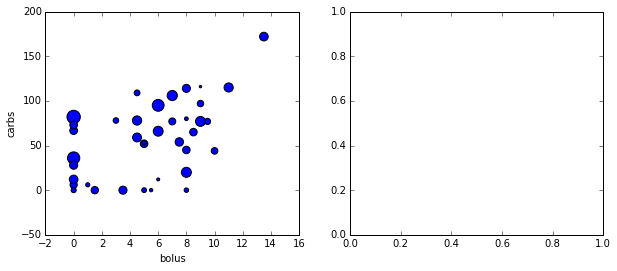

In [6]:
fig, axes = subplots(1, 2, figsize=(10,4))

axes[0].set_ylabel('carbs')
axes[0].set_xlabel('bolus')
axes[0].scatter(BOL, CAR, s=DBG)

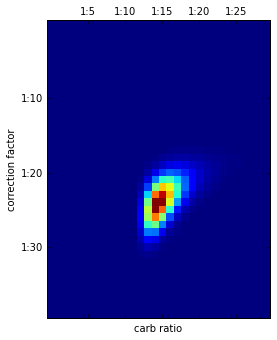

In [7]:
# def prior():
#     basal = np.linspace(1, 30, 30)
#     k_corr = np.linspace(1, 150, 150)
#     k_food = np.linspace(1, 30, 30)
#     return [(ba,kc,kf)
#            for kc in k_corr
#            for kf in k_food
#            for ba in basal]

# def make_map(d):
#     return np.array(range(d[0], d[2]+1, d[1]))

# basal_def = (1, 1, 30)
# corr_def = (5, 5, 100)
# food_def = (1, 1, 30)

# basal_map = make_map(basal_def)
# corr_map = make_map(corr_def)
# food_map = make_map(food_def)

# th = normalize(np.ones((len(basal_map), len(corr_map), len(food_map))))
# pylab.matshow(th[14])
# pylab.xticks()

def likelihood(bg0, bg1, ins, carb, basal, corr, kf):
    if kf == 0:
        return 0
    exp_bg1 = bg0 + float(carb)/kf*corr - ins*corr
    bg_sigma = 20
    return stats.norm.pdf(bg1, loc=exp_bg1, scale=bg_sigma)
    

def update(th, bg0, bg1, ins, carb):
    for basal in range(1):
        for corr in range(40):
            for food in range(30):
                th[basal,corr,food] *= likelihood(bg0, bg1, ins, carb, basal, corr, food)
    return normalize(th)

th = normalize(np.ones((1, 40, 30)))
th = update(th, 276, 61, 11, 30)
th = update(th, 129, 175, 3, 40)
th = update(th, 69, 103, 0, 30)
th = update(th, 171, 69, 12, 120)
pylab.matshow(th[0])
pylab.ylabel("correction factor")
pylab.yticks([10, 20, 30], ["1:10", "1:20", "1:30"])
pylab.xlabel("carb ratio")
pylab.xticks([5, 10, 15, 20, 25], ["1:5", "1:10", "1:15", "1:20", "1:25"])
pylab.show()

In [38]:
class Glucose(Suite, Joint):
    
    def __init__(self, k_carbs, k_corrs):
        models = [(k_carb, k_corr)
                  for k_carb in k_carbs
                  for k_corr in k_corrs]
        Suite.__init__(self, models)
    
    def Likelihood(self, data, model):
        (k_carb, k_corr) = model
        (bg0, bg1, ins, carb) = data
        if k_carb == 0:
            return 0
        exp_bg1 = bg0 + float(carb)/k_carb*k_corr - ins*k_corr
        bg_sigma = 20
        return stats.norm.pdf(bg1, loc=exp_bg1, scale=bg_sigma)
    

def update(th, bg0, bg1, ins, carb):
    for basal in range(1):
        for corr in range(40):
            for food in range(30):
                th[basal,corr,food] *= likelihood(bg0, bg1, ins, carb, basal, corr, food)
    return normalize(th)

suite = Glucose(range(1,40), range(1,30))
suite.UpdateSet([
        (276, 61, 11, 30),
        (129, 175, 3, 40),
        (69, 103, 0, 30),
        (171, 69, 12, 120)
    ])

print(suite)

# pylab.matshow(th[0])
# pylab.ylabel("correction factor")
# pylab.yticks([10, 20, 30], ["1:10", "1:20", "1:30"])
# pylab.xlabel("carb ratio")
# pylab.xticks([5, 10, 15, 20, 25], ["1:5", "1:10", "1:15", "1:20", "1:25"])
# pylab.show()

AttributeError: 'dict' object has no attribute 'itervalues'

total: 13.49963965692037


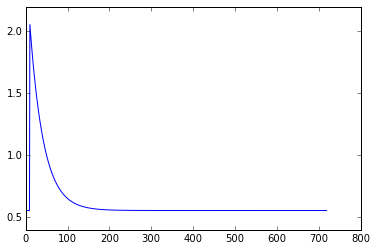

In [32]:
def gen(t_start,t_end, basals):
    (is0,iv0) = (10, 1.5)
    
    def basal_at(t):
        bv = 0
        for (t_basal,b) in basals:
            if t < t_basal:
                break
            bv = b
        return bv

    t = t_start - 60*4 # time for basal to settle
    ret = []
    ii = 0
    ir = 0.97
    i_sum = 0
    while t < t_end:
        if t == is0:
            ii = ii + iv0
        bv = basal_at(t)
        ii = ii + bv/60
        if t >= t_start:
            ret.append(ii)
        di = (1-ir)*ii
        ii = ii - di
        if t >= t_start:
            i_sum = i_sum + di
        t = t + 1
    return (ret,i_sum)

basals = [
    (-9999, 0.475), # U/hr
    (60, 0.5),
    (120, 0.2)
]

basals = [
    (-9999, 1)
]


(iob,i_total) = gen(0, 60*12, basals)
print("total:", i_total)
pylab.plot(iob)

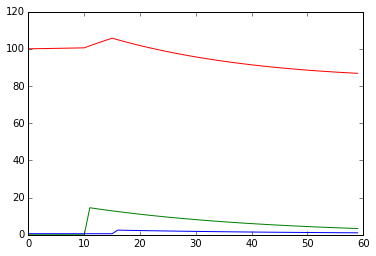

In [78]:
def step(data, food, bolus, basal, k_carb, k_corr, q_basal):
    (iob0, cob0, bg0) = data
    iob = iob0 + bolus + basal/60
    cob = cob0 + food
    di = (1-0.97)*iob
    dc = (1-0.97)*cob # should be shorter, should model differently?
    bg = bg0 - (di-q_basal/60)*k_corr + dc*k_carb
    return (iob-di, cob-dc, bg)


def likelihood(bg0, bg1, t0, t1, food, bolus, basals, k_carb, k_corr, q_basals):
    t = t0
    v = (0, 0, bg0)
    if kf == 0:
        return 0
    exp_bg1 = bg0 + float(carb)/kf*corr - ins*corr
    bg_sigma = 20
    return stats.norm.pdf(bg1, loc=exp_bg1, scale=bg_sigma)
    

def update(th, bg0, bg1, ins, carb):
    print("update")
    for corr in range(20,40):
        for food in range(10,30):
            for b1 in range(10):
#                 for b7 in range(10):
                    for b13 in range(10):
#                         for b19 in range(10):
                            basals = [
                                (60*-12, b13/10.),
#                                 (60*-6, b19/10.),
                                (60*0, b1/10.),
#                                 (60*6, b7/10.),
                                (60*12, b13/10.),
#                                 (60*18, b19/10.)
                            ]
                            l = likelihood(bg0, bg1, ins, carb, corr, food, basals)
                            th[corr,food,b1,b13] *= l
    return normalize(th)
